In [1]:
import torch
import torchvision.transforms as tt
from torch.utils.data import DataLoader
import torch.nn as nn
import os                                                              
import cv2 as cv                                                         
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from torcheval.metrics import PeakSignalNoiseRatio

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
df = pd.read_csv("./dataset/metadata.csv")
df.head()

,image_id,clear_image_path,hazy_image_paths,trans_image_paths
0,1,clear/1.png,"['hazy/1_1_0.90179.png', 'hazy/1_2_0.97842.png...","['trans/1_1.png', 'trans/1_2.png', 'trans/1_3...."
1,2,clear/2.png,"['hazy/2_1_0.99082.png', 'hazy/2_2_0.76381.png...","['trans/2_1.png', 'trans/2_2.png', 'trans/2_3...."
2,3,clear/3.png,"['hazy/3_1_0.88255.png', 'hazy/3_2_0.9726.png'...","['trans/3_1.png', 'trans/3_2.png', 'trans/3_3...."
3,4,clear/4.png,"['hazy/4_1_0.7483.png', 'hazy/4_2_0.92872.png'...","['trans/4_1.png', 'trans/4_2.png', 'trans/4_3...."
4,5,clear/5.png,"['hazy/5_1_0.85143.png', 'hazy/5_2_0.92675.png...","['trans/5_1.png', 'trans/5_2.png', 'trans/5_3...."


In [4]:
df.iloc[1,2][2:-2].split( sep = "', '") #to be used in pairimages function

['hazy/2_1_0.99082.png',
 'hazy/2_2_0.76381.png',
 'hazy/2_3_0.71438.png',
 'hazy/2_4_0.70173.png',
 'hazy/2_5_0.7745.png',
 'hazy/2_6_0.94385.png',
 'hazy/2_7_0.99118.png',
 'hazy/2_8_0.78092.png',
 'hazy/2_9_0.85023.png',
 'hazy/2_10_0.8305.png']

In [5]:
transforms = tt.Compose([
    tt.ToTensor(),
    tt.Resize((128,128))
])

In [6]:
class data_processor:
    def __init__(self, path, df, transforms):
        self.df = df
        self.path = path
        self.transforms = transforms
        self.pairimages()
        self.convert()
        

    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        x_i = self.ximg[idx]
        y_i = self.yimg[int(idx/10)]        
        return x_i , y_i
        
    def pairimages(self):
        self.x = []
        self.y = []
        for i in self.df.values:
            x_ = i[2] [2:-2].split( sep = "', '")
            self.x.extend(x_)
            y_ = i[1]
            self.y.append(y_)
            
    def convert(self):
        self.ximg = []
        self.yimg = []

        for idx in range(len(self.x)):
            x_i = self.x[idx]
            hazy_img = cv.cvtColor(cv.imread(os.path.join(self.path, x_i)), cv.COLOR_BGR2RGB)            
            if self.transforms is not None:
                hazy_img = self.transforms(hazy_img).cuda()
            self.ximg.append(hazy_img)
            
        for idx in range(len(self.y)):
            y_i = self.y[idx]
            clear_img = cv.cvtColor(cv.imread(os.path.join(self.path, y_i)), cv.COLOR_BGR2RGB)
            if self.transforms is not None:
                clear_img = self.transforms(clear_img).cuda()
            self.yimg.append(clear_img)
        

In [7]:
class Dataset:
    def __init__(self, path, df, transforms = None, ntrain = 250, ntest = 50, nval = 20):
        self.path = path
        self.df = df
        self.traindf = df.iloc[0 : ntrain]
        self.testdf = df.iloc[ntrain : ntrain + ntest]
        self.valdf = df.iloc[ntrain + ntest : ntrain + ntest + nval]
          
        self.train = data_processor(self.path, self.traindf, transforms)
        self.test = data_processor(self.path, self.testdf, transforms)
        self.val = data_processor(self.path, self.valdf, transforms)

In [8]:
path = os.path.join(os.getcwd(), 'dataset')
dataset = Dataset(path, df, transforms)

In [9]:
dataset.train[0][0].shape , dataset.train[0][1].shape
dataset.train[1][0].shape , dataset.train[1][1].shape
dataset.train[2][0].shape , dataset.train[2][1].shape
dataset.train[3][0].shape , dataset.train[3][1].shape
dataset.train[4][0].shape , dataset.train[4][1].shape
dataset.train[5][0].shape , dataset.train[5][1].shape
dataset.train[6][0].shape , dataset.train[6][1].shape
dataset.train[7][0].shape , dataset.train[7][1].shape
dataset.train[8][0].shape , dataset.train[8][1].shape

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]))

In [10]:
train_loader = DataLoader(dataset.train , batch_size=32, shuffle=True)
test_loader = DataLoader(dataset.test , batch_size=32, shuffle=False)
val_loader = DataLoader(dataset.val , batch_size=32, shuffle=False)

In [11]:
for x,y in enumerate(train_loader):
    print(x)
    print(y[0].shape)
    break;

0
torch.Size([32, 3, 128, 128])


In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [15]:
model_save_path = os.path.join(os.getcwd(), "models/unet1.pth")
model_save_path

'C:\\Users\\vibhu\\Desktop\\image dehaze\\models/unet1.pth'

In [16]:
model = UNet(in_channels=3, num_classes=3).to(device)
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
EPOCHS = 10
stime = time.time()
test_loss_his =[10000]
for epoch in range(EPOCHS):
        model.train()
        train_running_loss = 0
        print("Epoch",epoch+1,end="->")
        start_time = time.time()
        for idx, img_pair in enumerate(train_loader):
            img = img_pair[0]
            orig = img_pair[1]

            y_pred = model(img)
            optimizer.zero_grad()

            loss = criterion(y_pred, orig)
            train_running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            if((idx+1)%7==0):
                print("=" , end="")
        train_loss = train_running_loss / (idx + 1)
        print("100 %", end=" ")
        print(int(time.time()-start_time), "s" , end = " ")
        model.eval()
        test_running_loss = 0
        with torch.no_grad():
            for idx, img_pair in enumerate(test_loader):
                img = img_pair[0]
                orig = img_pair[1]
                
                y_pred = model(img)
                loss = criterion(y_pred, orig)

                test_running_loss += loss.item()

            test_loss = test_running_loss / (idx + 1)
        print("-"*5 , end= " ")
        print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}" , end= " | ")
        print(f"Test Loss EPOCH {epoch+1}: {test_loss:.4f}", end=" ")
        if(test_loss<test_loss_his[-1]):
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            test_loss_his.append(test_loss)
            print("-"*5 , "Updated")
        else:
            print("-"*5 , "Not Updated")

print("Total time", int(time.time() - stime)," s")
print("Best Test loss", test_loss_his[-1])

Epoch 1->===========100 % 42 s ----- Train Loss EPOCH 1: 0.0830 | Test Loss EPOCH 1: 0.0333 ----- Updated
Epoch 2->===========100 % 27 s ----- Train Loss EPOCH 2: 0.0286 | Test Loss EPOCH 2: 0.0255 ----- Updated
Epoch 3->===========100 % 27 s ----- Train Loss EPOCH 3: 0.0231 | Test Loss EPOCH 3: 0.0214 ----- Updated
Epoch 4->===========100 % 27 s ----- Train Loss EPOCH 4: 0.0205 | Test Loss EPOCH 4: 0.0266 ----- Not Updated
Epoch 5->===========100 % 27 s ----- Train Loss EPOCH 5: 0.0196 | Test Loss EPOCH 5: 0.0159 ----- Updated
Epoch 6->===========100 % 27 s ----- Train Loss EPOCH 6: 0.0165 | Test Loss EPOCH 6: 0.0151 ----- Updated
Epoch 7->===========100 % 27 s ----- Train Loss EPOCH 7: 0.0155 | Test Loss EPOCH 7: 0.0174 ----- Not Updated
Epoch 8->===========100 % 27 s ----- Train Loss EPOCH 8: 0.0136 | Test Loss EPOCH 8: 0.0121 ----- Updated
Epoch 9->===========100 % 27 s ----- Train Loss EPOCH 9: 0.0123 | Test Loss EPOCH 9: 0.0119 ----- Updated
Epoch 10->===========100 % 27 s ----- 

In [17]:
def pred_show_image_grid(dataset, model_pth, num, device):
    model = UNet(in_channels=3, num_classes=3).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    
    images = []

    for i in range(0,num*10,10):
        img = dataset.val.ximg[i]
        img = img.unsqueeze(0)

        pred = model(img)
        pred[pred < 0]=0 # to remove artificats when values >1 or <0 are clipped  
        pred[pred > 1]=1
        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        pred = pred.squeeze(0).cpu().detach()
        pred = pred.permute(1, 2, 0)

        orig = dataset.val.yimg[int(i/10)].cpu().detach()
        orig = orig.permute(1, 2, 0)

        images.append([img, pred, orig])
    
    names = ["Hazy image", "Pred image", "Clear image"]
    for i, l in enumerate(images, start=1):
        fig = plt.figure(figsize=(3*5 , num*5))
        for j, image in enumerate(images[i-1], start=1):
            ax = fig.add_subplot(i, 3, j)
            ax.imshow((image * 255).numpy().astype(np.uint8))
        
            ax.axis('off')  # Hide the axes
    plt.show()


def single_image_inference(hazy_image_pth, clear_image_pth, model_pth, transform,  device):
    model = UNet(in_channels=3, num_classes=3).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


    img = transform(cv.cvtColor(cv.imread(hazy_image_pth), cv.COLOR_BGR2RGB)).float().to(device)
    img = img.unsqueeze(0)
   
    pred = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    clear_img = transform(cv.cvtColor(cv.imread(clear_image_pth), cv.COLOR_BGR2RGB)).float().to(device)
    clear_img = clear_img.squeeze(0).cpu().detach()
    clear_img = clear_img.permute(1, 2, 0)

    pred = pred.squeeze(0).cpu().detach()
    pred = pred.permute(1, 2, 0)
    print(torch.min(pred))
    pred[pred < 0]=0 # to remove artificats when values >1 or <0 are clipped  
    pred[pred > 1]=1

    names = ["Hazy image", "Pred image", "Clear image"]
    fig = plt.figure(figsize=(15,5))
    for i, image in enumerate([img, pred, clear_img], start=1):
        ax = fig.add_subplot(1, 3, i)
        ax.imshow((image * 255).numpy().astype(np.uint8))
        ax.axis('off')  # Hide the axes
        ax.set_title(names[i-1])
    plt.show()

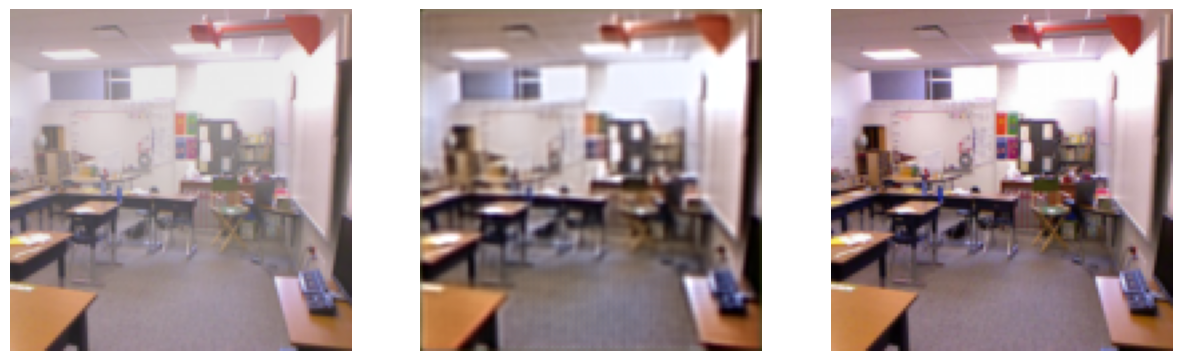

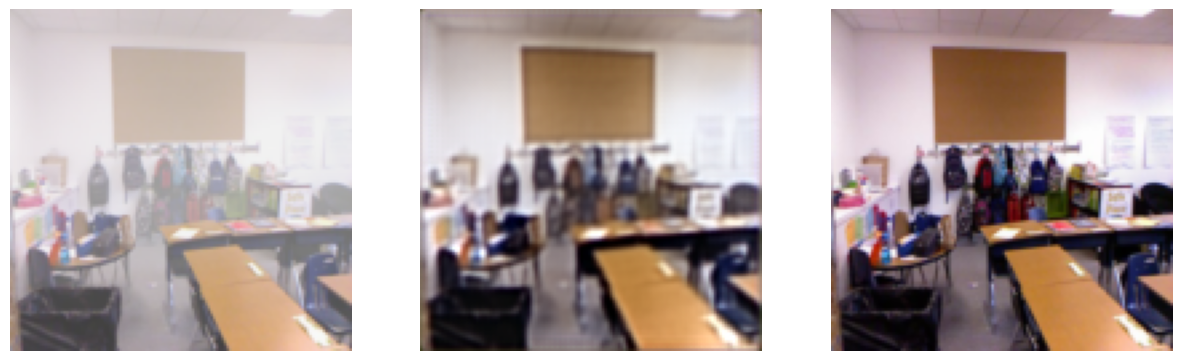

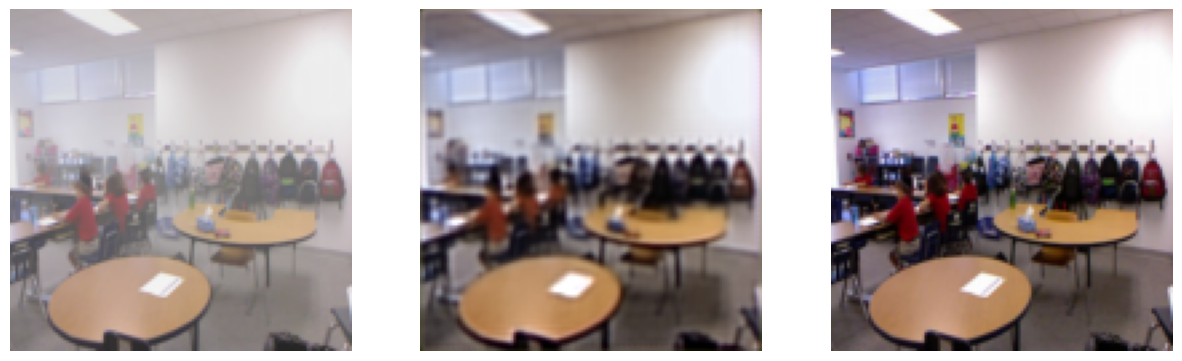

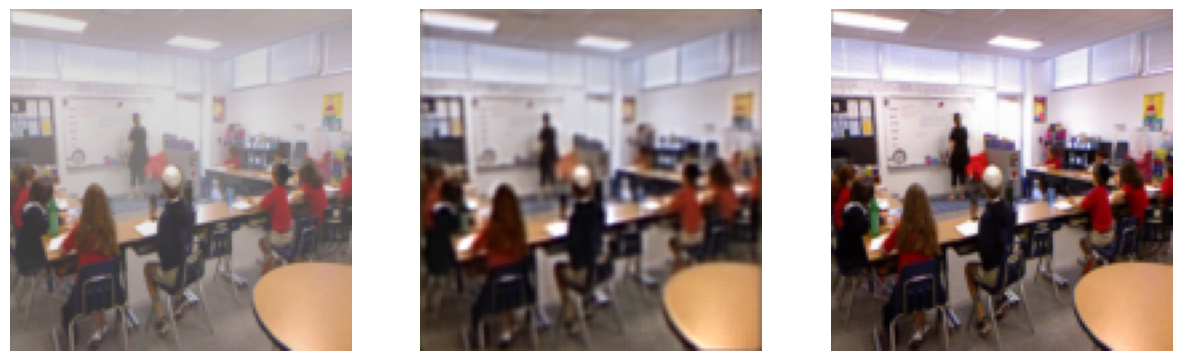

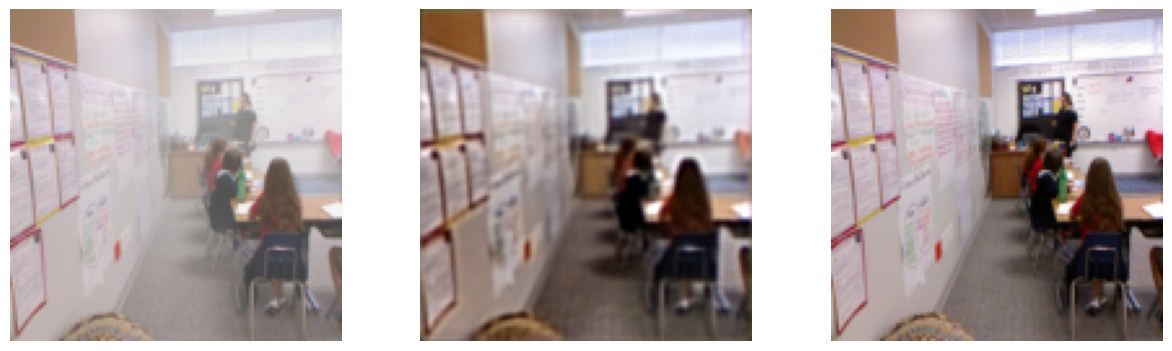

tensor(-0.0209)


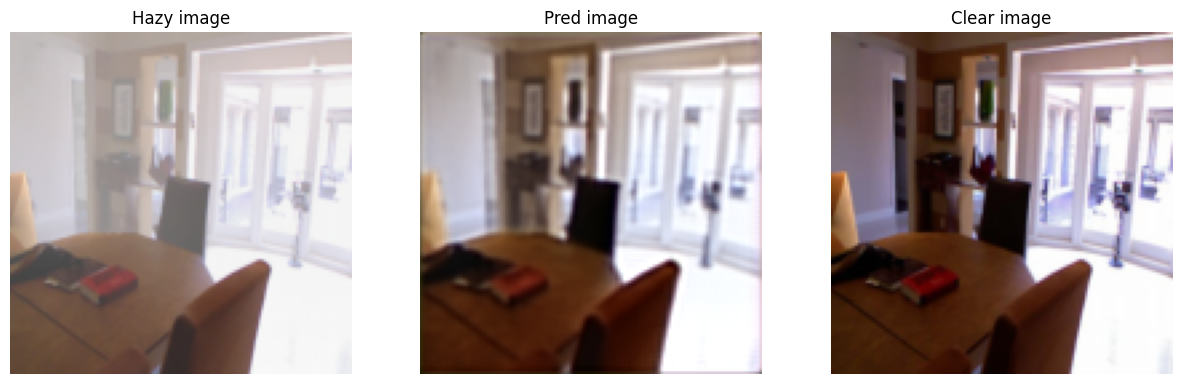

In [18]:
single_img_path = "./dataset/hazy/1393_7_0.94045.png"
single_clear_img_path = "./dataset/clear/1393.png"
model_path = "./models/unet1.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
pred_show_image_grid(dataset, model_path, 5, device)
single_image_inference(single_img_path, single_clear_img_path, model_path, transforms, device)

In [23]:
def psnr_metric(dataloader, model_pth, device):
    model = UNet(in_channels=3, num_classes=3).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    metric = PeakSignalNoiseRatio()

    for i in dataloader:
        img = i[0]
        orig = i[1]
        pred = model(img)
        metric.update(pred,img)
    print('PSNR: ', metric.compute().item())
model_path = "./models/unet1.pth"
psnr_metric(val_loader, model_path, device)

PSNR:  14.649856567382812
